# Hotel rating prediction

In [124]:
# import main librariees
import numpy as np 
import pandas as pd 
from IPython.display import clear_output
import os, sys, time, json, re

# set random seed
random_seed = 42

# Graphical libraries
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
%matplotlib inline

# nlp processing
import nltk 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import Blobber
from textblob.sentiments import NaiveBayesAnalyzer

# ML libraries
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor,StackingRegressor 
from sklearn import metrics # 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_predict, RandomizedSearchCV, StratifiedKFold
import pickle
import joblib
import optuna

from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.tree import DecisionTreeRegressor

!pip freeze > requirements.txt

In [125]:
#set path
sys.path.insert(1, '../')

from utils.config_reader import config_reader

# custom functions
from utils.functions import get_address, get_neutral_from_negative, \
    get_traveller, get_trip_type, get_stay_length, get_room_type_prep, get_room_type

# Import parameters
config = config_reader('../config/config.json')

# set data folder path
data_dir = config.data_dir

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
df_train = pd.read_csv(data_dir + 'hotels.zip') # train
df_test = pd.read_csv(data_dir+'hotels_test.zip') # test
sample_submission = pd.read_csv(data_dir+'submission.zip') # submission

In [126]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [127]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [128]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [129]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [130]:
sample_submission.head()

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596


In [131]:
sample_submission['reviewer_score'].value_counts()

5     13079
10    13021
2     12955
6     12940
8     12887
1     12850
9     12829
3     12825
7     12820
4     12729
Name: reviewer_score, dtype: int64

In [132]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [133]:
# Lets mark train and test data
df_train['sample'] = 1 # train  
df_test['sample'] = 0  # test

# let us create target feature in test data
df_test['reviewer_score'] = 0 # fill with zeros

# join train and test data for prediction
data = df_test.append(df_train, sort=False).reset_index(drop=True) 

# Drop useless feature
data.drop(['hotel_name'], axis=1, inplace=True)

In [134]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   reviewer_nationality                        515738 non-null  object 
 5   negative_review                             515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   total_number_of_reviews                     515738 non-null  int64  
 8   positive_review                             515738 non-null  object 
 9   review_total_positive_word_counts           515738 non-null  int64  
 

## Categorical features

In [135]:
categorical_columns_names = [s for s in data.columns if data[s].dtypes == 'object'] 
numerical_columns_names =   [s for s in data.columns if data[s].dtypes != 'object']
categorical_columns_names

['hotel_address',
 'review_date',
 'reviewer_nationality',
 'negative_review',
 'positive_review',
 'tags',
 'days_since_review']

### Hotel address

In [136]:
print(data['hotel_address'].value_counts().head(1), data['hotel_address'].value_counts().tail(2))

163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom    4789
Name: hotel_address, dtype: int64 13 Rue Fran ois Ory 92120 Paris France                     10
Johann Staud Stra e 32 16 Ottakring 1160 Vienna Austria     8
Name: hotel_address, dtype: int64


In [137]:
data['country'] = data['hotel_address'].apply(lambda x: \
    (x.split()[-2] + ' '+ x.split()[-1]) if x.split()[-1]=='Kingdom' else  x.split()[-1])

data['city'] = data['hotel_address'].apply(lambda x: x.split()[-5] if x.split()[-1]=='Kingdom' else  x.split()[-2]) 

print(' ')    
print(data['country'].value_counts(),' ', data['city'].value_counts())
data.drop(['hotel_address'], axis=1, inplace=True)

 
United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: country, dtype: int64   London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: city, dtype: int64


### Negative reviews

In [138]:
# change feature type
data['negative_review'] = data['negative_review'].astype('object')
data['negative_review'].value_counts().head()

No Negative    127890
 Nothing        14295
 Nothing         4236
 nothing         2225
 N A             1037
Name: negative_review, dtype: int64

In [139]:
# Delete space and lower case
data['negative_review'] = data['negative_review'].apply(lambda x: x.lower() if x=='No Negative' else x.lower()[1:])
data['negative_review'] = data['negative_review'].str.strip()
#data['negative_review'] = data['negative_review'].apply(get_negative_reasons)
#data['negative_review'].value_counts()

#### Separate neutral feedbacks

In [140]:
# data['clas_neutral_review'] = data['negative_review'].apply(get_neutral_from_negative)
# data['clas_neutral_review'].value_counts().head()

In [141]:
blobber = Blobber(analyzer=NaiveBayesAnalyzer())
# classification review by NaiveBayesAnalyzer to negative and positive 
data['clas_neg_review'] = data['negative_review'].apply(lambda x: blobber(x).sentiment.classification)

# drop original feature 'negative_review'
data.drop(['negative_review'], axis=1, inplace=True)

### Positive reviews

In [142]:
data['positive_review'].value_counts().head()

No Positive    35946
 Location       9222
 Everything     2284
 location       1677
 Nothing        1243
Name: positive_review, dtype: int64

As it can be seen, some rows contain spaces prior to first word. Let us delete it

In [143]:
# Delete space and lower case
data['positive_review'] = data['positive_review'].apply(lambda x: x.lower() if x=='No Positive' else x.lower()[1:])

data['positive_review'] = data['positive_review'].str.strip()
#data['positive_review_encoding'] = data['positive_review'].apply(get_find_reasons)
data['positive_review'].value_counts().head(10)

no positive           35946
location              11945
everything             3314
nothing                1731
great location         1687
the location           1606
good location          1496
breakfast               795
friendly staff          733
excellent location      639
Name: positive_review, dtype: int64

In [144]:
#data['positive_review'] = data['positive_review'].apply(get_positive_reasons)
#data['positive_review'].value_counts().head(10)
data['clas_pos_review'] = data['positive_review'].apply(lambda x: blobber(x).sentiment.classification)

# drop original feature 'positive_review'
data.drop(['positive_review'], axis=1, inplace=True)

In [145]:
display(data['clas_neg_review'].value_counts())
print('')
display(data['clas_pos_review'].value_counts())

pos    352195
neg    163543
Name: clas_neg_review, dtype: int64

pos    387969
neg    127769
Name: clas_pos_review, dtype: int64

### Reviewer nationality

In [146]:
display(data['reviewer_nationality'].value_counts().nlargest(10).index)
display(data['reviewer_nationality'].iloc[0])

Index([' United Kingdom ', ' United States of America ', ' Australia ',
       ' Ireland ', ' United Arab Emirates ', ' Saudi Arabia ',
       ' Netherlands ', ' Switzerland ', ' Germany ', ' Canada '],
      dtype='object')

' United Kingdom '

In [147]:
# Del spaces at the end of each row if any
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x[1:-1:1])

# Creation of a new feature *same nationality*. 
data['nationality_same_as_country'] = data.apply(lambda x: 1 if x['reviewer_nationality'] == x['country'] else 0, axis=1).astype('int16')
data['nationality_same_as_country'].value_counts()

# Feature reduction to 14 most frequent nationalities. The rest are named as 'other'.
most_frequent_nationalities = data['reviewer_nationality'].value_counts().nlargest(14).index.to_list()
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in most_frequent_nationalities else 'other')
data['reviewer_nationality'].value_counts().head()

United Kingdom              245246
other                       120020
United States of America     35437
Australia                    21686
Ireland                      14827
Name: reviewer_nationality, dtype: int64

### Tags

In [148]:
data['tags'].explode().value_counts().nlargest(10)

[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']              5101
[' Leisure trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']     4931
[' Leisure trip ', ' Couple ', ' Superior Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']     4366
[' Leisure trip ', ' Couple ', ' Deluxe Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']       3991
[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']             3291
[' Leisure trip ', ' Couple ', ' Superior Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']    3102
[' Leisure trip ', ' Couple ', ' Standard Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']    2947
[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ']                                                  2906
[' Leisure trip ', ' Cou

#### Traveller type

In [149]:
data['traveller_type'] = data['tags'].apply(get_traveller)
data['traveller_type'].value_counts().head()

 Couple                        245754
 Solo traveler                 104060
 Group                          63649
 Family with young children     58573
 Family with older children     25326
Name: traveller_type, dtype: int64

In [150]:
# Feature reduction to 6 most frequent types
popular_travellers_types = data['traveller_type'].value_counts().nlargest(6).index
print(popular_travellers_types)

data['traveller_type'] = data['traveller_type'].apply(lambda x: x if x in popular_travellers_types else ' Other')
data['traveller_type'].value_counts().head()

Index([' Couple', ' Solo traveler', ' Group', ' Family with young children',
       ' Family with older children', ' Travelers with friends'],
      dtype='object')


 Couple                        245754
 Solo traveler                 104060
 Group                          63649
 Family with young children     58573
 Family with older children     25326
Name: traveller_type, dtype: int64

#### Trip types

In [151]:
data['trip_type'] = data['tags'].apply(get_trip_type)
data['trip_type'].value_counts().head()

Leisure trip     416672
Business trip     82748
Couple             5808
Solo traveler      4291
Family             3158
Name: trip_type, dtype: int64

In [157]:
fig = px.pie(
    data,
    names='trip_type',
    width=400,
    height=400,
)

fig.update_layout(
    title=dict(text='Fig.1 - Trip types', x=.5, y=0.1, xanchor='center'),
)
fig.update_traces(textposition='inside', textinfo='percent+label')
#fig.show()

fig.write_image('../figures/fig_1.png');

<center> <img src = "../figures/fig_1.png">

#### Stay duration

In [158]:
data['stay_length'] = data['tags'].apply(get_stay_length)
#data['stay_length'].value_counts().head()
data['stay_length'].value_counts().head()

1    193645
2    133937
3     95821
4     47817
5     20845
Name: stay_length, dtype: int64

In [159]:
data['stay_length'].value_counts().tail()

26    7
28    7
24    6
29    5
31    1
Name: stay_length, dtype: int64

In [160]:
# Feature reduction 10 categories
data['stay_length'] = data['stay_length'].apply(lambda x: 10 if x > 9 else x)

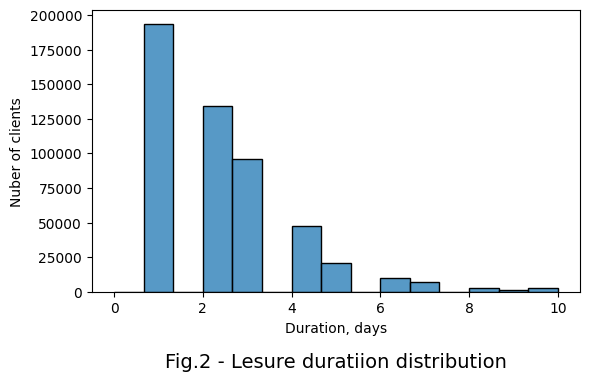

In [214]:
fig = plt.figure(figsize=(6, 4))

hist = sns.histplot(
    data=data,
    x='stay_length', 
    bins=15,
    #kde=True,
);
hist.set(xlabel='Duration, days', ylabel='Nuber of clients')
hist.set_title('Fig.2 - Lesure duratiion distribution', y=-0.3, fontsize=14)
plt.tight_layout();

plt.savefig(f'../figures/fig_2.png')

#### Room types

In [162]:
data['room_type'] = data['tags'].apply(get_room_type_prep)
data['room_type'].value_counts().nlargest(15)

 Double Room                     34027
 Standard Double Room            31242
 Superior Double Room            30460
 Deluxe Double Room              24001
 Double or Twin Room             21732
 Standard Double or Twin Room    16978
 Classic Double Room             16553
 Superior Double or Twin Room    13245
 2 rooms                         12054
 Standard Twin Room               9346
 Single Room                      9239
 Twin Room                        7950
 Executive Double Room            6229
 Classic Double or Twin Room      5985
 Deluxe Double or Twin Room       5838
Name: room_type, dtype: int64

In [163]:
room_types = data['room_type'].astype('str').apply(get_room_type)
room_types.value_counts().nlargest(15)

Double Room    293654
Family Room    188507
Single Room     24305
Triple Room      9272
Name: room_type, dtype: int64

In [165]:
# Reduction of types
popular_room_types = room_types.value_counts().nlargest(6).index
print(popular_room_types)

data['room_type'] = room_types.apply(lambda x: x if x in popular_room_types else 'other')

# Del original feature 'room_type'
data.drop(['room_type'], axis=1, inplace=True)

Index(['Double Room', 'Family Room', 'Single Room', 'Triple Room'], dtype='object')


In [166]:
# drop original feature
data.drop(['tags'], axis=1, inplace=True)

### review_date

In [167]:
# Creation of a new feature
data['review_date'] = pd.to_datetime(data['review_date'], errors='coerce', format='%m/%d/%Y')

# Get review date
data['days_since_review'] = ((data['review_date'].max() - data['review_date'])/np.timedelta64(1,'D')).astype(int)
data['review_month'] = data['review_date'].dt.month.astype(int)
data['review_day'] = data['review_date'].dt.day.astype(int)
data['review_weekday'] = data['review_date'].dt.dayofweek.astype(int)

# drop original feature
data.drop(['review_date'], axis=1, inplace=True)

## Numerical features

### Hotels coordinates: 'lat' and 'lng'

In [168]:
# Missing values identification
cols_null_percent = round(data.isnull().mean() * 100, 2)
cols_with_null = cols_null_percent[cols_null_percent > 0].sort_values(ascending=False)
print(f"Features with missing values, %: \n{cols_with_null}")

Features with missing values, %: 
lat    0.63
lng    0.63
dtype: float64


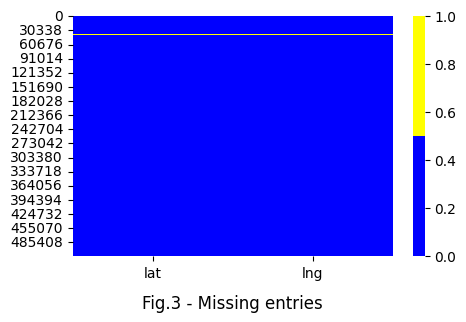

In [172]:
colors = ['blue', 'yellow'] 
fig, ax = plt.subplots(figsize=(5,3))
fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.5,
                    hspace=0.4)

cols = cols_with_null.index
fig= sns.heatmap(
    data[cols].isnull(),
    cmap=sns.color_palette(colors), ax=ax
)
fig.set_title('Fig.3 - Missing entries', y=-0.25);
#ax.set_yticks(range(0, 500000, 100000));

In [40]:
# addresses with missing entries
null_addresses = list(set(data[data['lat'].isnull()]['city']))

null_cities = list()
for x in null_addresses:
    null_cities.append(x) 
    
# set of unique cities
distinct_cities=list(set(null_cities))

#display(f'Number of missing entries: {len(null_cities)}')
display(f'There are: {len(set(null_cities))} distinct cities: {distinct_cities}')

"There are: 3 distinct cities: ['Paris', 'Vienna', 'Barcelona']"

Get city centers by coordinates from Google maps.

In [41]:
# City center coordinates
city_center_coordinates = {
    'Vienna': [48.210033, 16.363449],
    'Barcelona': [41.390205, 2.154007],
    'Paris': [48.864716, 2.349014]
}

lat_mask = data['lat'].isnull()
lng_mask = data['lng'].isnull()

for city, coordinates in city_center_coordinates.items():
    data.loc[(lat_mask & (data['city'] == city)), 'lat'] = coordinates[0]
    data.loc[(lng_mask & (data['city'] == city)), 'lng'] = coordinates[1]
    
# Get missing entries share by feature
display(data.isnull().mean().head())

additional_number_of_scoring         0.0
average_score                        0.0
reviewer_nationality                 0.0
review_total_negative_word_counts    0.0
total_number_of_reviews              0.0
dtype: float64

## Normalization of humerical features

In [42]:
# Let us exclude following features
exclusion = ['lat', 'lng', 'sample', 'nationality_same_as_country', 'reviewer_score']

num_features = [s for s in data.columns if data[s].dtypes != 'object' and s not in exclusion]
num_features

['additional_number_of_scoring',
 'average_score',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'days_since_review',
 'stay_length',
 'review_month',
 'review_day',
 'review_weekday']

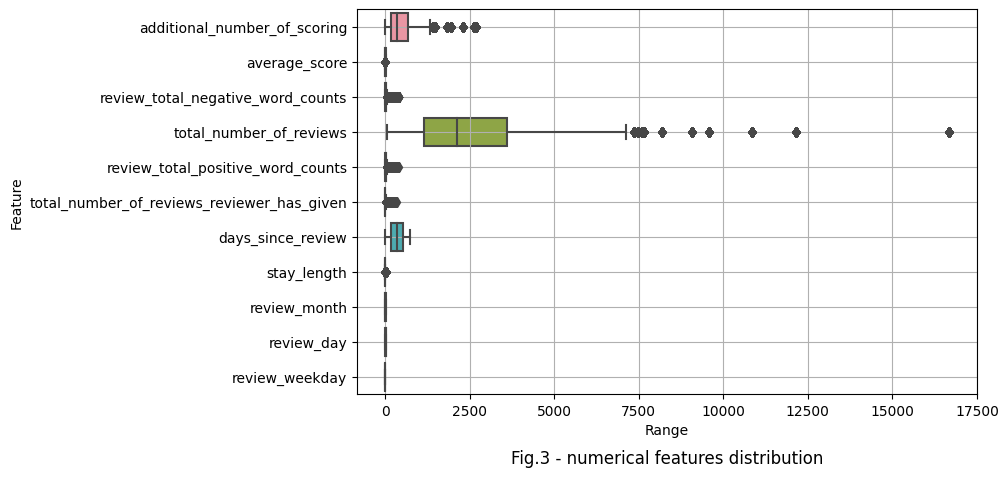

In [43]:
fig = plt.figure(figsize=(8, 5))

boxplot = sns.boxplot(data=data[num_features], orient='h')
boxplot.set_title('Fig.4 - numerical features distribution', y=-0.2, fontsize=12)
boxplot.set_xlabel('Range')
boxplot.set_ylabel('Feature')
boxplot.grid();

In [44]:
data[num_features].agg(['min','mean', 'max']).round(2).T

,min,mean,max
additional_number_of_scoring,1.0,498.08,2682.0
average_score,5.2,8.40,9.8
review_total_negative_word_counts,0.0,18.54,408.0
total_number_of_reviews,43.0,2743.74,16670.0
review_total_positive_word_counts,0.0,17.78,395.0
total_number_of_reviews_reviewer_has_given,1.0,7.17,355.0
days_since_review,0.0,354.44,730.0
stay_length,0.0,2.35,10.0
review_month,1.0,6.49,12.0
review_day,1.0,15.68,31.0


1 stage

In [45]:
# How many unique values contain features
print('Unique values in features:')
for col in data[num_features].columns.tolist()[:24]:
    print(f'{col}: {data[col].nunique()}')

Unique values in features:
additional_number_of_scoring: 480
average_score: 34
review_total_negative_word_counts: 402
total_number_of_reviews: 1142
review_total_positive_word_counts: 365
total_number_of_reviews_reviewer_has_given: 198
days_since_review: 731
stay_length: 11
review_month: 12
review_day: 31
review_weekday: 7


In [46]:
# Initialization of the RobustScaler
r_scaler = preprocessing.RobustScaler()

# copu dataset
data_norm = data[num_features].copy() #

# transform and join
data_norm_rs = r_scaler.fit_transform(data_norm)
data_norm_rs = pd.DataFrame(data_norm_rs, columns=num_features)

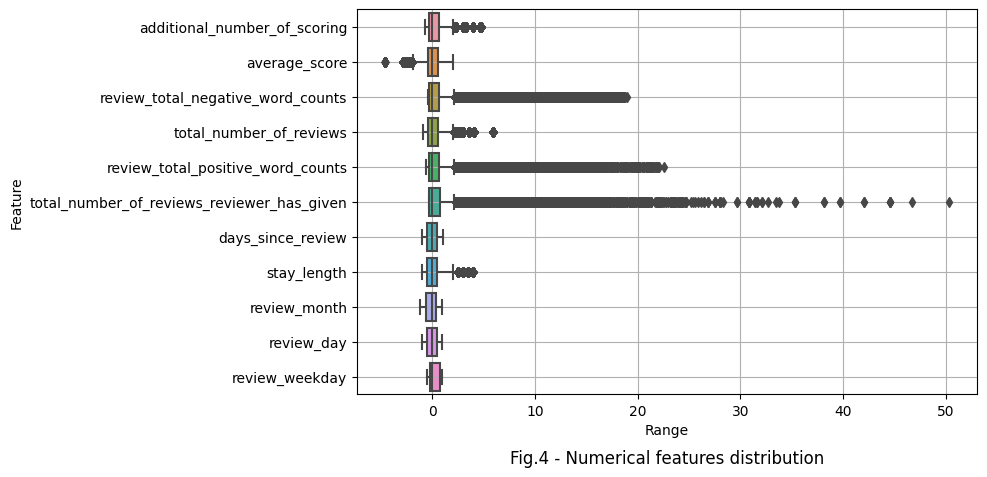

In [47]:
#categorical_columns_names, numerical_columns_names = get_sort_features(data)

# # Визуализация
# fig, ax = plt.subplots(ncols=1, figsize=(10, 6))

# for col in numerical_columns_names:
#     sns.kdeplot(data_norm_rs[col], ax=ax)
    
# ax.set_title('Рис.4 - Normalized features after RobustScaler', y=-0.2, fontsize=12)
# ax.legend(numerical_columns_names)
# ax.set_xlabel('Признак')
# ax.set_ylabel('Значение');

fig = plt.figure(figsize=(8, 5))

boxplot = sns.boxplot(data=data_norm_rs, orient='h')
boxplot.set_title('Fig.5 - Numerical features distribution', y=-0.2, fontsize=12)
boxplot.set_xlabel('Range')
boxplot.set_ylabel('Feature')
boxplot.grid();

Join transformed features to the dataFrame

In [48]:
data.drop(num_features, axis=1, inplace=True)
data = data.join(data_norm_rs)
data.head(2)

,reviewer_nationality,lat,lng,sample,reviewer_score,country,city,clas_neg_review,clas_pos_review,nationality_same_as_country,...,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,stay_length,review_month,review_day,review_weekday
0,United Kingdom,45.533137,9.171102,0,0.0,Italy,Milan,pos,pos,0,...,-0.428571,2.047619,5.928222,3.000000,-0.285714,-0.965909,0.0,0.0,0.333333,0.5
1,Belgium,52.385649,4.834443,0,0.0,Netherlands,Amsterdam,neg,neg,0,...,0.285714,0.047619,1.176183,-0.647059,0.571429,-0.338068,-0.5,1.0,-0.266667,-0.5


## Categorical features encoding

In [49]:
cat_features = [s for s in data.columns if data[s].dtypes == 'object']
len(cat_features)

7

In [50]:
data = pd.get_dummies(data) #, columns=categorical_columns_names
data.columns

Index(['lat', 'lng', 'sample', 'reviewer_score', 'nationality_same_as_country',
       'additional_number_of_scoring', 'average_score',
       'review_total_negative_word_counts', 'total_number_of_reviews',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'days_since_review',
       'stay_length', 'review_month', 'review_day', 'review_weekday',
       'reviewer_nationality_Australia', 'reviewer_nationality_Belgium',
       'reviewer_nationality_Canada', 'reviewer_nationality_France',
       'reviewer_nationality_Germany', 'reviewer_nationality_Ireland',
       'reviewer_nationality_Israel', 'reviewer_nationality_Italy',
       'reviewer_nationality_Netherlands', 'reviewer_nationality_Saudi Arabia',
       'reviewer_nationality_Switzerland',
       'reviewer_nationality_United Arab Emirates',
       'reviewer_nationality_United Kingdom',
       'reviewer_nationality_United States of America',
       'reviewer_nationality_other', 'country_A

## Multicollinearity study

In [51]:
# Find features with high correlation power
pivot = data.corr()
pivot = pivot.drop('sample', axis=0)
pivot = pivot.drop('sample', axis=1)

for col in pivot:
    pivot[col] = pivot[col].apply(lambda x: np.nan if (abs(x) < 0.7 or x == 1) else x)
    
for col in pivot:
    pivot = pivot.dropna(how='all')
    pivot = pivot.dropna(how='all', axis='columns')

high_correlation_features = list(pivot.columns) # список признаков c высокой корреляцией
pivot 

print('Features with high correlation coeff:')
for count, value in enumerate(high_correlation_features, start=1): # list features from 1
    print(count, value)

Features with high correlation coeff:
1 lat
2 lng
3 nationality_same_as_country
4 additional_number_of_scoring
5 total_number_of_reviews
6 reviewer_nationality_United Kingdom
7 country_Austria
8 country_Spain
9 city_Barcelona
10 city_Vienna
11 clas_neg_review_neg
12 clas_neg_review_pos
13 clas_pos_review_neg
14 clas_pos_review_pos
15 trip_type_Business trip
16 trip_type_Leisure trip


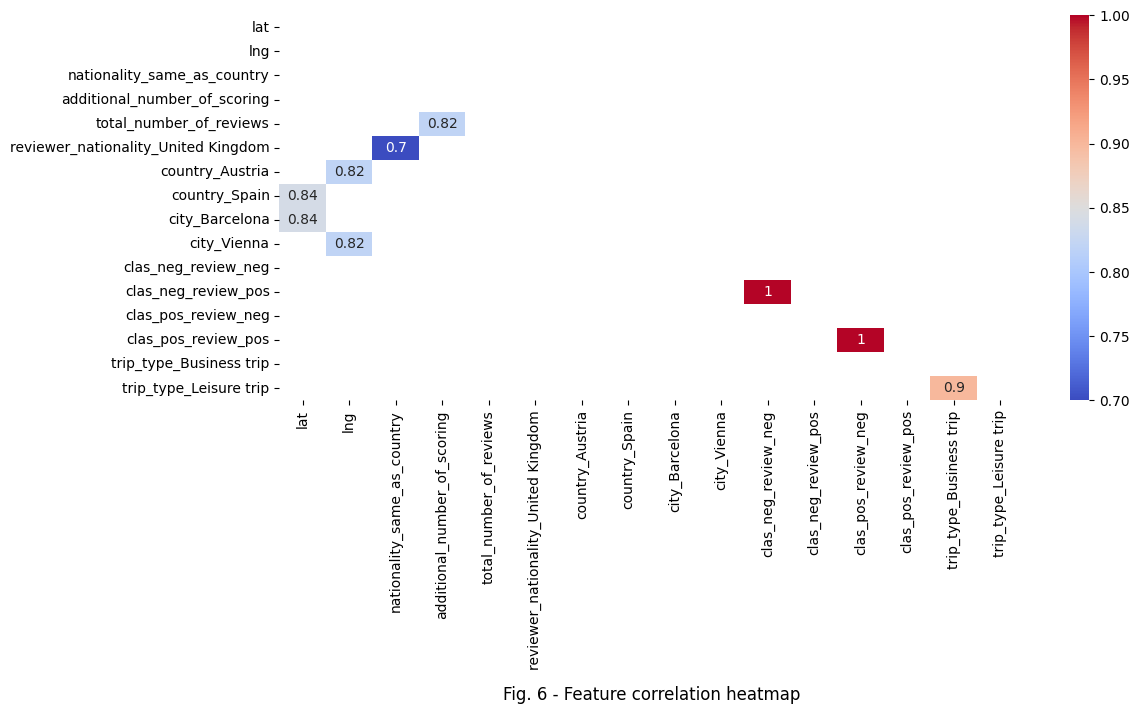

In [52]:
fig, ax = plt.subplots(ncols=1, figsize=(12, 5))

matrix = np.triu(pivot)  
fig = sns.heatmap(round(abs(pivot),2), annot=True,  cmap= 'coolwarm', mask=matrix) #, vmin=-1, vmax=1, center= 0, fmt='.02g',
ax.set_title('Fig. 6 - Feature correlation heatmap', y=-0.8, fontsize=12)
ax.tick_params(axis='x', rotation=90);

In [53]:
# Drop features with high multicorrelation power
counter = 0
for lower_bound in np.linspace(0.98, 0.7, num=14):
    for col in pivot:
        if pivot[col].max() > lower_bound or pivot[col].min() < -lower_bound:
            #pivot = pivot.drop(col, axis=0)
            pivot = pivot.drop(col, axis=1)
            #data = data.drop(col, axis=1)
            counter += 1
            
print('Deleted', counter, 'columns')

Deleted 16 columns


In [54]:
# fig, ax = plt.subplots(ncols=1, figsize=(30, 25))

# matrix = np.triu(data.corr())  
# fig = sns.heatmap(round(abs(data.corr()),2), annot=True,  cmap= 'coolwarm', mask=matrix) #, vmin=-1, vmax=1, center= 0, fmt='.02g',
# ax.set_title('Рис. 6 - Тепловая карта корреляции переменных', y=-0.15, fontsize=12);

In [55]:
data['sample'].value_counts()

1    386803
0    128935
Name: sample, dtype: int64

## Modelling

In [56]:
data.dtypes.value_counts()

# drop object type features if any
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [57]:
# Select the test sample
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

X, y  = train_data.drop(['reviewer_score'], axis=1), train_data['reviewer_score'].values  # target feature

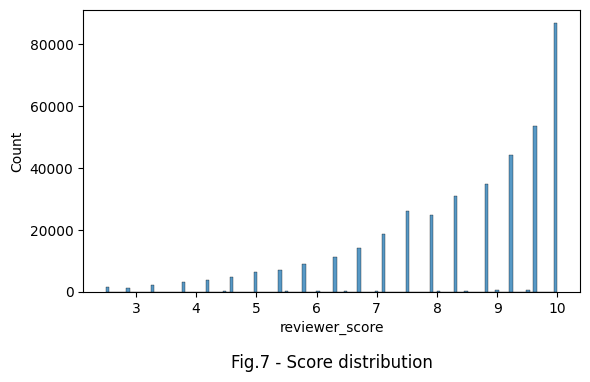

In [215]:
#display(train_data['reviewer_score'].value_counts(normalize=True))

fig, ax = plt.subplots(figsize = (6, 4))
ax = sns.histplot(data=train_data, x='reviewer_score')
ax.set_title('Fig.7 - Score distribution', y=-0.3);
plt.tight_layout()

plt.savefig('../figures/fig_7.png');

In [84]:
# Split data by 3 samples: train, test and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=0.2, random_state=random_seed)
X_test, X_valid, y_test, y_valid  = train_test_split(X_valid, y_valid, test_size=0.5, random_state=random_seed)

# Check samples shapes
print('Train shape: {}'.format(X_train.shape))
print('Test shape:  {}'.format(X_test.shape))
print('Valid shape: {}'.format(X_valid.shape))

Train shape: (309442, 59)
Valid shape: (38681, 59)
Test shape:  (38680, 59)


### Random forest

In [98]:
model_rf = RandomForestRegressor(n_estimators=100, 
                                 verbose=1, n_jobs=-1, 
                                 random_state=random_seed)

#Train model
model_rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished


RandomForestRegressor(n_jobs=-1, random_state=42, verbose=1)

In [100]:
y_pred_rf = model_rf.predict(X_valid[1:])

print(' MAE: {:.2}'.format(metrics.mean_absolute_error(y_test, y_pred_rf)))
print(f"MAPE: {round(metrics.mean_absolute_percentage_error(y_test, y_pred_rf)*100, 2)} %")

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


 MAE: 1.5
MAPE: 22.29 %


[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.3s finished


In [68]:
# # в RandomForestRegressor есть возможность вывести самые важные признаки для модели
# plt.rcParams['figure.figsize'] = (6,6)
# feat_importances = pd.Series(model.feature_importances_, index=X.columns)
# feat_importances.nlargest(15).plot(kind='barh')

#### Save model 

Saved model is about 320 Mb and it is better not to save it

In [69]:
# # Save model to the given path in the pkl format
# model_path = config.model_path
# full_path = os.path.join(model_path, 'model_rf.pkl')

# # with open(full_path, 'wb') as f:
# #     pickle.dump(model_rf, f)

# with open(full_path, 'wb') as f:
#     joblib.dump(model_rf, f, compress=5)

### Model 2. Random forest + cross validation

In [70]:
# % time
# param_distributions = {
#     'n_estimators': list(range(400, 500, 100)),
#     #'criterion': ['squared_error', 'absolute_error'],
#     #'max_depth': list(np.linspace(5, 45, 15, dtype=int)),
#     #'min_samples_leaf': list(range(3, 12, 3)),
#     "bootstrap":[True]
# }
            
# random_search_forest = RandomizedSearchCV(
#     estimator=ensemble.RandomForestRegressor(random_state=random_seed), 
#     param_distributions=param_distributions, 
#     cv=5,
#     n_iter = 5, 
#     n_jobs = -1
# )  

# random_search_forest.fit(X_train, y_train) 

# y_train_pred = random_search_forest.predict(X_train)
# y_test_pred = random_search_forest.predict(X_test)
# print('f1_score for validation sample: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
# print("Best hyperparameters are: {}".format(random_search_forest.best_params_))

# # save best parameters to a new dict
# best_params_rf = random_search_forest.best_params_

### Model 3. Random forest + optuna

In [71]:
# def optuna_rf(trial):
#     # hyperparameters range
#     n_estimators = trial.suggest_int('n_estimators', 400, 500, 100)
#     #max_depth = trial.suggest_int('max_depth', 30, 50, 10)
#     #min_samples_leaf = trial.suggest_int('min_samples_leaf', 4, 12, 3)
    
#     # create the model
#     model = ensemble.RandomForestRegressor(
#         n_estimators=n_estimators,
#         #max_depth=max_depth,
#         #min_samples_leaf=min_samples_leaf,
#         #criterion=criterion,
#         random_state=random_seed
#     )
    
#     # train model
#     model.fit(X_train, y_train)
#     score = metrics.mean_absolute_error(y_train, model.predict(X_train)).round(4)

#     return score

In [72]:
# %%time

# # Creation of an instance of optuna class
# study = optuna.create_study(study_name="RandomForestRegressor", direction="minimize")

# # tyr to find best hyperparameters n_trials times
# study.optimize(optuna_rf, n_trials=2)

# #clear_output(wait=False)

# # Display optimized hyperparameters by optuna
# print("Best hyperparameters {}".format(study.best_params))
# print("Best MAE: {:.2f}".format(study.best_value))
# best_params_opt = study.best_params

In [73]:
#optuna.visualization.plot_optimization_history(study, target_name="f1_score")

## Model 4. Stacking

In [86]:
# Initiate estimators
estimators = [
    ('linear', LinearRegression()),
    ('dt',  RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=random_seed))
]

# Create an instance of the stacking class
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(
        n_estimators=100,
        random_state=random_seed)
)
# Training the model
reg.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n

StackingRegressor(estimators=[('linear', LinearRegression()),
                              ('dt',
                               RandomForestRegressor(n_jobs=-1, random_state=42,
                                                     verbose=1))],
                  final_estimator=RandomForestRegressor(random_state=42))

In [97]:
# get the prediction
y_pred_st_lin = reg.predict(X_valid[1:]) #X_test

print(' MAE: {:.2}'.format(metrics.mean_absolute_error(y_test, y_pred_st_lin)))
print(f"MAPE: {round(metrics.mean_absolute_percentage_error(y_test, y_pred_st_lin)*100, 2)} %")

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.3s finished


 MAE: 1.6
MAPE: 22.75 %


## Stacking

In [95]:
estimators2 = [
    ('lr', RidgeCV()),
    ('dt',  DecisionTreeRegressor(random_state=random_seed))
]

# Create an instance of the stacking class
model_stacking = StackingRegressor(
    estimators=estimators2,
    final_estimator=RandomForestRegressor(n_estimators=100, random_state=random_seed)
)
# Model training
model_stacking.fit(X_train, y_train)

StackingRegressor(estimators=[('lr', RidgeCV()),
                              ('dt', DecisionTreeRegressor(random_state=42))],
                  final_estimator=RandomForestRegressor(random_state=42))

In [96]:
y_pred_st_r = model_stacking.predict(X_valid[1:])

print(' MAE: {:.2}'.format(metrics.mean_absolute_error(y_test, y_pred_st_r)))
print(f"MAPE: {round(metrics.mean_absolute_percentage_error(y_test, y_pred_st_r)*100, 2)} %")

 MAE: 1.6
MAPE: 23.03 %


# Submission

In [79]:
test_data.sample(10)

,lat,lng,reviewer_score,nationality_same_as_country,review_month,review_day,review_weekday,additional_number_of_scoring,average_score,review_total_negative_word_counts,...,traveller_type_ Other,traveller_type_ Solo traveler,traveller_type_ Travelers with friends,trip_type_Business trip,trip_type_Couple,trip_type_Family,trip_type_Group,trip_type_Leisure trip,trip_type_Solo traveler,trip_type_With a pet
59979,41.381042,2.181429,0.0,0,6,20,0,-0.456212,1.000000,0.380952,...,0,0,0,0,0,0,0,1,0,0
67026,48.879595,2.328069,0.0,0,5,19,4,-0.543788,0.428571,-0.428571,...,0,0,0,0,0,0,0,1,0,0
67758,51.513734,-0.108751,0.0,1,2,16,1,0.606925,1.142857,0.238095,...,0,0,0,0,0,0,0,1,0,0
72344,52.368130,4.844085,0.0,0,11,2,2,1.191446,-0.285714,2.476190,...,0,0,0,0,0,0,0,1,0,0
110623,51.512974,-0.183743,0.0,0,4,26,1,1.745418,0.142857,-0.333333,...,0,1,0,1,0,0,0,0,0,0
24721,45.470238,9.195347,0.0,0,6,2,4,-0.474542,1.142857,-0.333333,...,0,0,0,0,0,0,0,1,0,0
21947,51.512974,-0.183743,0.0,1,6,29,2,1.745418,0.142857,-0.428571,...,0,1,0,1,0,0,0,0,0,0
106998,52.372707,4.894366,0.0,0,7,8,5,0.863544,0.000000,1.714286,...,0,0,0,0,0,0,0,1,0,0
116928,51.526535,-0.136168,0.0,1,3,20,0,0.437882,-0.571429,3.000000,...,0,1,0,1,0,0,0,0,0,0
62027,51.514573,-0.156660,0.0,0,2,27,5,-0.175153,-0.428571,0.666667,...,0,1,0,1,0,0,0,0,0,0


In [80]:
test_data = test_data.drop(['reviewer_score'], axis=1)
test_data.head()

,lat,lng,nationality_same_as_country,review_month,review_day,review_weekday,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,...,traveller_type_ Other,traveller_type_ Solo traveler,traveller_type_ Travelers with friends,trip_type_Business trip,trip_type_Couple,trip_type_Family,trip_type_Group,trip_type_Leisure trip,trip_type_Solo traveler,trip_type_With a pet
0,45.533137,9.171102,0,7,21,4,1.146640,-0.428571,2.047619,5.928222,...,0,0,0,0,0,0,0,1,0,0
1,52.385649,4.834443,0,12,12,0,0.551935,0.285714,0.047619,1.176183,...,0,0,0,0,0,0,0,1,0,0
2,41.393192,2.161520,0,11,26,3,-0.600815,-0.142857,-0.285714,-0.727162,...,0,1,0,1,0,0,0,0,0,0
3,45.479888,9.196298,0,10,17,5,-0.203666,1.000000,-0.428571,-0.241028,...,0,0,0,0,0,0,0,1,0,0
4,52.370545,4.888644,0,5,16,0,1.004073,1.000000,-0.428571,1.041191,...,0,1,0,1,0,0,0,0,0,0


In [81]:
sample_submission.head()

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [82]:
predict_submission = model_rf.predict(test_data)
predict_submission

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    3.8s finished


array([8.659, 6.762, 8.429, ..., 7.721, 9.624, 7.031])

In [83]:
predict_submission = np.round(predict_submission, 1)
predict_submission

array([8.7, 6.8, 8.4, ..., 7.7, 9.6, 7. ])

In [84]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission_alex_1.csv', index=False)
sample_submission.head(2)

,reviewer_score,id
0,8.7,488440
1,6.8,274649


## K-fold method (cross validation)

In [101]:
# model creation
model_rf_cv = RandomForestRegressor(
    n_estimators=100, verbose=1, n_jobs=-1, random_state=random_seed)
 
# Cross-validator instance KFold
kf = KFold(n_splits=5)
 
# Display metrics for k-fold
cv_metrics = cross_validate(
    estimator=model_rf_cv, # model
    X=X,  
    y=y,  
    cv=kf, # cross-validator
    scoring=('neg_mean_absolute_error','neg_mean_absolute_percentage_error'), # metrics set
    return_train_score=True # return metrics for training folds
)
display(cv_metrics)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Paral

{'fit_time': array([105.98539925,  88.56191897,  87.08225226,  84.77181768,
         84.31459546]),
 'score_time': array([0.9823823 , 0.87721181, 0.77961898, 0.77498746, 0.73522735]),
 'test_neg_mean_absolute_error': array([-0.91383814, -0.92204438, -0.92155621, -0.92001177, -0.9221638 ]),
 'train_neg_mean_absolute_error': array([-0.34235003, -0.3408752 , -0.34152486, -0.34172378, -0.34081692]),
 'test_neg_mean_absolute_percentage_error': array([-0.13169558, -0.13357012, -0.13330004, -0.13298192, -0.13310202]),
 'train_neg_mean_absolute_percentage_error': array([-0.04945745, -0.04920456, -0.04930535, -0.049322  , -0.04922604])}

In [106]:
cv_metrics.keys()

dict_keys(['fit_time', 'score_time', 'test_neg_mean_absolute_error', 'train_neg_mean_absolute_error', 'test_neg_mean_absolute_percentage_error', 'train_neg_mean_absolute_percentage_error'])

In [103]:
# Lets study metrics

print('Train k-fold MAE: {:.2f}  MAPE: {:.4f}'.format(
    np.mean(cv_metrics['train_neg_mean_absolute_error']), 
    np.mean(cv_metrics['train_neg_mean_absolute_percentage_error'])))
print('Test k-fold MAE: {:.2f}  MAPE: {:.4f}'.format(
    np.mean(cv_metrics['test_neg_mean_absolute_error']), 
    np.mean(cv_metrics['test_neg_mean_absolute_percentage_error'])))

Train k-fold MAE: -0.34  MAPE: -0.0493
Test k-fold MAE: -0.92  MAPE: -0.1329


In [105]:
# Train model
model_rf_cv.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished


In [117]:
y_pred_rf_cv = model_rf_cv.predict(X_valid[1:])

print(' MAE: {:.2}'.format(metrics.mean_absolute_error(y_test, y_pred_rf_cv)))
print(f"MAPE: {round(metrics.mean_absolute_percentage_error(y_test, y_pred_rf_cv)*100, 2)} %")

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


 MAE: 1.5
MAPE: 22.29 %


[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.3s finished


lat                                              0.041100
lng                                              0.041184
nationality_same_as_country                      0.003067
additional_number_of_scoring                     0.035899
average_score                                    0.083880
review_total_negative_word_counts                0.252033
total_number_of_reviews                          0.037532
review_total_positive_word_counts                0.100271
total_number_of_reviews_reviewer_has_given       0.033914
days_since_review                                0.063296
stay_length                                      0.021467
review_month                                     0.029870
review_day                                       0.047513
review_weekday                                   0.025313
reviewer_nationality_Australia                   0.002293
reviewer_nationality_Belgium                     0.001187
reviewer_nationality_Canada                      0.001374
reviewer_natio

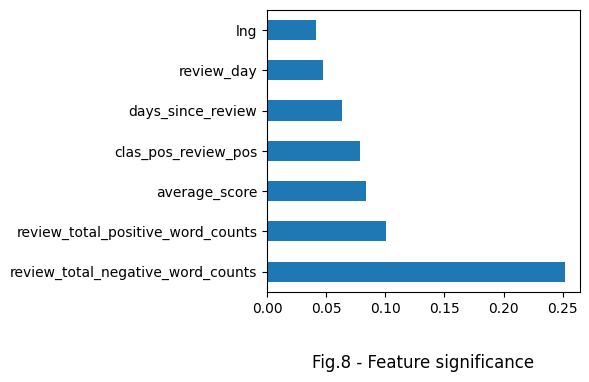

In [216]:
feat_significance = pd.Series(model_rf_cv.feature_importances_, index=X.columns).sort_values(ascending=False).nlargest(7)
fig, ax = plt.subplots(figsize = (6, 4))
fig = feat_significance.plot(kind='barh')
fig.set_title('Fig.8 - Feature significance', y=-0.3);
plt.tight_layout()
plt.savefig('../figures/fig_8.png');

## Model study

In [120]:
y_pred_rf_cv

array([7.909, 7.875, 9.356, ..., 7.039, 9.251, 8.704])

In [194]:
from sklearn.metrics import PredictionErrorDisplay

In [200]:
len(y_pred_rf_cv)

38680

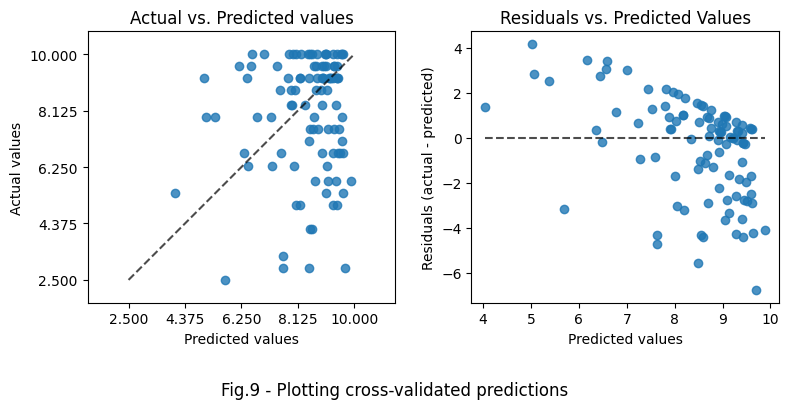

In [218]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_rf_cv,
    kind="actual_vs_predicted",
    subsample=100,
    ax=ax[0],
    random_state=0,
)
ax[0].set_title("Actual vs. Predicted values")

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_rf_cv,
    kind="residual_vs_predicted",
    subsample=100,
    ax=ax[1],
    random_state=0,
)
ax[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Fig.9 - Plotting cross-validated predictions", y=-0.05)
plt.tight_layout()

plt.savefig('../figures/fig_9.png');